<center><font size="15"><bold> HUB4045F</bold></font> </center>
<br> </br>
<center><font size="6"><light>Assignment 4</light></font> </center>
<br> </br>
<center><font size="4">By  Aadam Osman</font> <font size = "2">(OSMAAD003)</font> </center>
<br> </br>


# Installation Libraries important for this assignments

Please make sure you have homebrew installed. If on the off chance you don't have any of these libraries installed - please uncomment them and install

In [65]:
#!pip install sklearn
#!pip install shapely
#!pip install rtree
#!pip install openpyscad
#!brew install spatialindex
#!easy_install Rtree
#!pip install scikit-image

# Relevant Imports for this Assignment

In [298]:
from __future__ import division
import sys
import pydicom as DCM
import cv2
import numpy as np
from matplotlib import pyplot as plt,cm
import trimesh
import sklearn
from skimage.draw import circle
from scipy.spatial import procrustes
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial  import procrustes
%matplotlib inline

# Question 1

## (a)  - Display Image

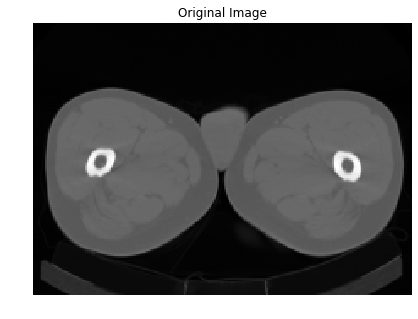

In [299]:
#read the DCM file
image = DCM.read_file('./CTimage.dcm')
#Normalize image file to gray scale, so can preform cv2 functions on it
image_n = cv2.normalize(image.pixel_array,image.pixel_array,0,255,cv2.NORM_MINMAX)
#display Original image
plt.figure(figsize=(10,5))
plt.imshow(image_n,'gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

## (b), (c), (d) - Segmenting 

### Isolating Entire Left Leg First Using Masks
#### Please Pay attention to my comments, as they explain my thought process

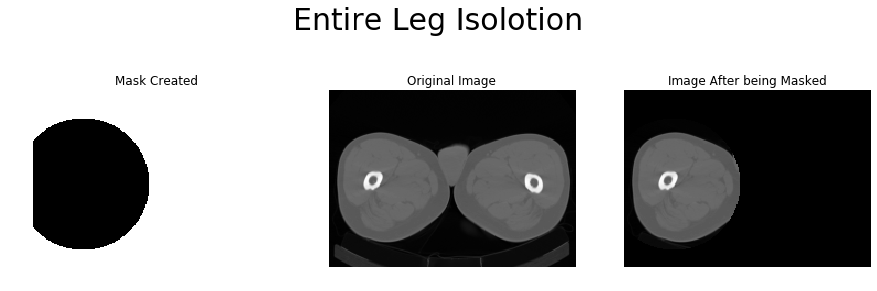

In [300]:
#given the image above,it is obvious that I need to isolate the entire left leg first
#so I made use of 2 masks, a circle and a square
#the circle is to isolate the left leg (but the mask wraps around)
#therefore a square mask was used to remove the wrap around

#mask creation
mask = np.ones(image_n.shape)
#creating a circle from skimage.draw
rr, cc = circle(85,45,60)
#create the circle in the mask
mask[rr,cc]=0

#Square mask to remove circle wrap around issue
square = np.zeros(image_n.shape)
square[:,int(len(image_n[0])/2):] = 1 # initiating mask

#update mask with submask
mask[square>0]=1

#create copy of image to preform mask
image_masked = image_n.copy()

#apply mask
image_masked[mask>0] = 0

#display 
fig = plt.figure(figsize=(15,5))
fig.suptitle('Entire Leg Isolotion',size =(30))
plt.subplot(1,3,1)
plt.imshow(mask,'gray')
plt.title('Mask Created')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_n, 'gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(image_masked,'gray')
plt.title('Image After being Masked')
plt.axis('off')
plt.show()

### Segmenting the relevant sections using threshold method 

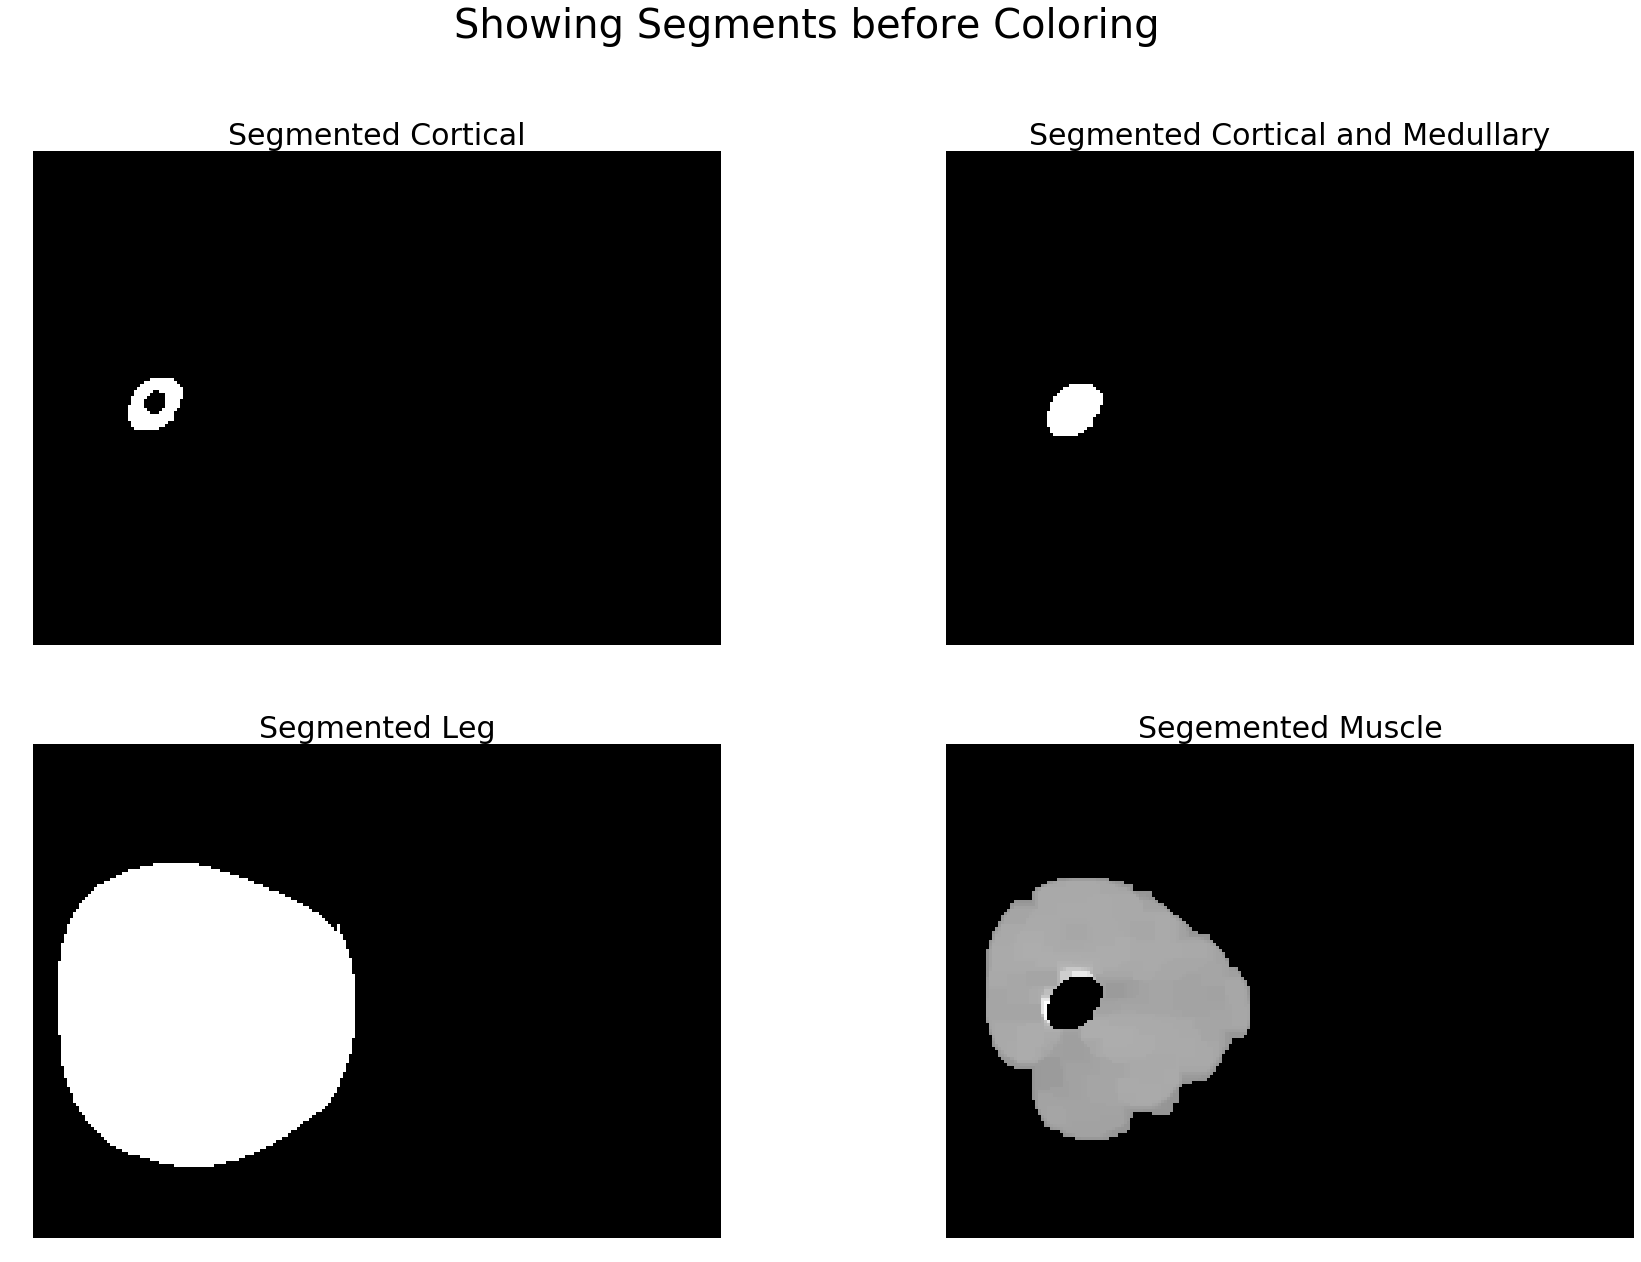

In [302]:
#Segementing cortical with Binary Threshold
cortical = cv2.threshold(image_masked,140,255,cv2.THRESH_BINARY)[1]

#Segmenting leg with Binary Threshold
leg = cv2.threshold(image_masked,79,255,cv2.THRESH_BINARY)[1]

#Segmenting Muscle with Binary first, but using ToZero Threshold provided a smother result so a comibation was used
muscle = cv2.threshold(image_masked,90,255,cv2.THRESH_BINARY + cv2.THRESH_TOZERO)[1] 



#Closing Cortical Area to include Medullary region by applying a Morphological Close
kernel = np.ones((4,4),np.uint8)
cortical_medullary_region =cv2.morphologyEx(cortical, cv2.MORPH_CLOSE, kernel, iterations=2)

#Removing random Artefacts (random dots) of the muscle that don't belong by applying Morphological Open
kernel = np.ones((2,2),np.uint8)
muscle =cv2.morphologyEx(muscle, cv2.MORPH_OPEN, kernel, iterations=4)

#Creating Continuity in muscle by closing it by using Morphological Close
kernel = np.ones((2,2),np.uint8)
muscle =cv2.morphologyEx(muscle, cv2.MORPH_CLOSE, kernel, iterations=4)

#It was noted that the muscle shifted when applying Morphological Close so transformation was applied
#Transforming Muscle to orginal position
nrows, ncols = muscle.shape
M1 = np.float32([[1,0,-8],[0,1,-8]])
muscle = cv2.warpAffine(muscle,M1,(ncols,nrows))

#remove Cortical Area and Medullary region from muscle image,
#so the area calculations do not include bone when calculting area of muslce
muscle[cortical_medullary_region>0]=0



#showing relevant plots
fig1 = plt.figure(1, figsize=(30,20))
fig1.suptitle('Showing Segments before Coloring',size=(40))
plt.subplot(2,2,1)
plt.imshow(cortical,'gray')
plt.axis('off')
plt.title('Segmented Cortical', size=(30))

plt.subplot(2,2,2)
plt.imshow(cortical_medullary_region,'gray')
plt.axis('off')
plt.title('Segmented Cortical and Medullary', size=(30))

plt.subplot(2,2,3)
plt.imshow(leg,'gray')
plt.axis('off')
plt.title('Segmented Leg', size=(30))
plt.subplot(2,2,4)
plt.imshow(muscle,'gray')
plt.axis('off')
plt.title('Segemented Muscle', size=(30))
plt.show()


### Color Labeling Process

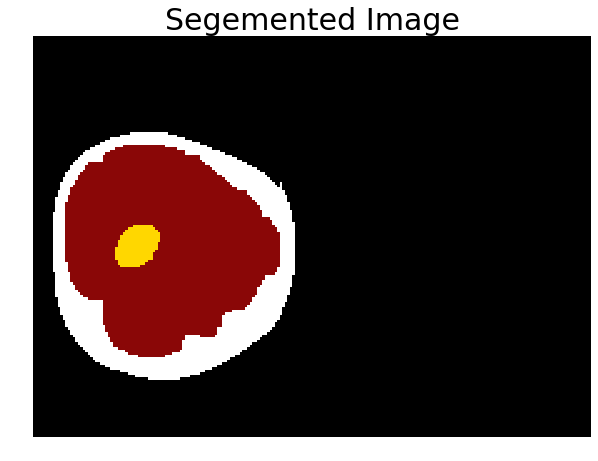

In [303]:
#color labeling process

#create a binary image so I can color approriately
leg[leg>0]=1
cortical_medullary_region[cortical_medullary_region>0]=1
muscle[muscle>0]=1

#color process
white = np.multiply.outer(leg, [255,255,255])
yellow = np.multiply.outer(cortical_medullary_region, [255,215,0])
red = np.multiply.outer(muscle, [138,7,7])

fig = plt.figure(figsize=(10,10))
#Overlaying Segemented labels
for i in range(len(yellow)):
    for b in range(len(yellow[0])):
        if(red[i][b][0]>0):
            white[i][b] = red[i][b]
        if (yellow[i][b][0]>0):
            white[i][b] = yellow[i][b]
plt.imshow(white)
plt.title('Segemented Image',size=(30))
plt.axis('off')
plt.show()


# Question 2

So in this process, what I thought was to first get the the area of a pixel (in mm<sup>2</sup>) , and then find out the pixel area of an the segments, and multiply the pixel area by this to find the area in mm<sup>2</sup>

In [304]:
#pixel area
pixel_area = float(image.PixelSpacing[0])*float(image.PixelSpacing[1])

#area of relevant segment
bone_area=(cortical_medullary_region>0).sum()*pixel_area
corical_area = (cortical>0).sum()*pixel_area
muscle_area =(muscle>0).sum()*pixel_area

print('Bone Area    : {ans} mm^2'.format(ans=bone_area))
print('Corical Area : {ans} mm^2'.format(ans=corical_area))
print('Muscle Area  : {ans} mm^2'.format(ans=muscle_area))

Bone Area    : 8.352796484214 mm^2
Corical Area : 6.8725540692900005 mm^2
Muscle Area  : 178.721649668562 mm^2


# Question 3

## (a) - showing the surfaces

In [305]:
mesh1 = trimesh.load('./Scapula1.ply')
mesh2 = trimesh.load('./Scapula2.ply')

In [306]:
#show Scapula 1
mesh1.show()

In [307]:
#show Scapula 2
mesh2.show()

## (b) - answering the question 

In [308]:
num_face_1 = len(mesh1.faces)
num_face_2 = len(mesh2.faces)

num_ver_1 = len(mesh1.vertices)
num_ver_2 = len(mesh2.vertices)

print("Number of faces of surface 1 and 2 are {face1} and {face2} respectively.\nNumber of vertices of surface 1 and 2 are {ver1} and {ver2} respectively".format(face1 = num_face_1, face2 =num_face_1, ver1 =num_ver_1, ver2 =num_ver_2))

Number of faces of surface 1 and 2 are 48332 and 48332 respectively.
Number of vertices of surface 1 and 2 are 24168 and 24168 respectively


**What would correspondence mean in the context of surfaces?**
* This would mean to have set of vertices that are spatially related in someway, even if offset by a rotation and translation, such that they "correspond" to each other, to represent a similar or iso-topological surface. In the context of the scapulas provided it can be noted that the vertices are in correspondence to each other - where the x co-ordinates of the two surfaces correspond as follows:

$$x_{scapula1}=-x_{scapula2}$$
$$y_{scapula1}=y_{scapula2}$$
$$z_{scapula1}=z_{scapula2}$$

**How many vertices does each surface have?**
* Scapula 1 has 24168 vertices
* Scapula 2 has 24168 vertices

**How many faces?**
* Scapula 1 has 48332 faces
* Scapula 2 has 48332 faces

**How would you confirm that they are indeed iso-topological?**
* I think the first thing to give it away is that they hace the same number of faces and vertices. 
* Secondly, to begin the confirmation process I would plot both surfaces together, and note that they are spatially rotated and translated pairs of each other (this is can be seen in the next code cell) and then further map these two surfaces on to each other (which is done in Question 4),and note that their features do allign to an extent.


In [309]:
#plotting both surfaces together
#to see they are translated and rotated versions of each other
(mesh1 + mesh2).show()

# Question 4

## (a) - Direct Method

The Problem faced here was to establish the correspondence point, and the only way to do this was by means of translating and rotating one surface on to the other and then add the two vertices and divide by two to get an average mesh surface. This was done using the relationship as follows:

$$x_{scapula1}=-x_{scapula2}$$
$$y_{scapula1}=y_{scapula2}$$
$$z_{scapula1}=z_{scapula2}$$

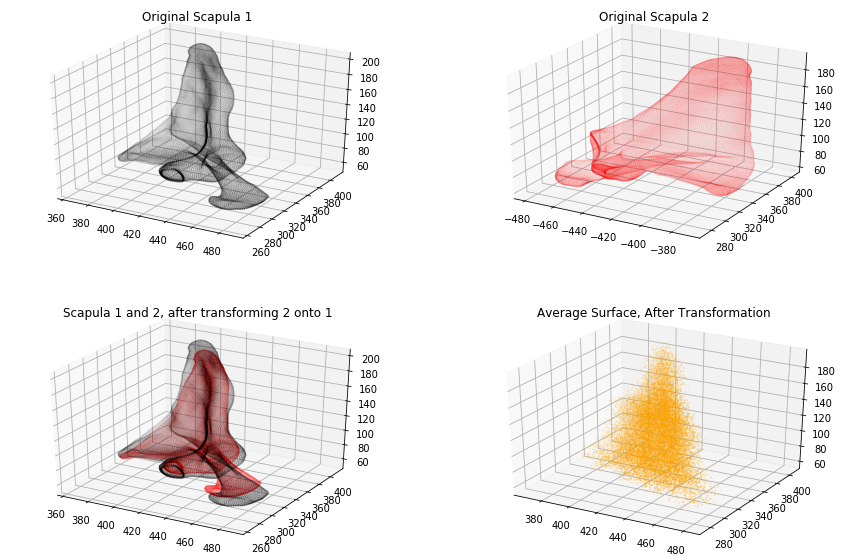

In [312]:
#average matrix to store average between the two vertices
average = []
#Create Deep copies of scapulas
mesh1_a= mesh1.copy()
mesh2_a = mesh2.copy()

#flip scapula 2 so that is on scapula 1
mesh2_a.vertices[:,0] = -1*mesh2_a.vertices[:,0]

#average the vertices as the correspondent points are alligned
average_a = (mesh2_a.vertices + mesh1_a.vertices)/2

#show relevant plots
fig = plt.figure(1, figsize = (15,10))
ax1 = fig.add_subplot(2,2,1, projection='3d')
ax1.scatter(mesh1.vertices[:,0],mesh1.vertices[:,1], mesh1.vertices[:,2], s=0.01, color = 'k')
plt.title('Original Scapula 1')

ax2 = fig.add_subplot(2,2,2, projection='3d')
ax2.scatter(mesh2.vertices[:,0],mesh2.vertices[:,1], mesh2.vertices[:,2], s=0.01, color='r')
plt.title('Original Scapula 2')


ax3 = fig.add_subplot(2,2,3, projection='3d')
ax3.scatter(mesh1_a.vertices[:,0],mesh1_a.vertices[:,1], mesh1_a.vertices[:,2], s=0.01, color = 'k')
ax3.scatter(mesh2_a.vertices[:,0],mesh2_a.vertices[:,1], mesh2_a.vertices[:,2], s=0.01, color='r')
plt.title('Scapula 1 and 2, after transforming 2 onto 1')

ax4 = fig.add_subplot(2,2,4, projection='3d')
ax4.scatter(average_a[:,0],average_a[:,1], average_a[:,2],s = 0.03,color = 'orange')
plt.title('Average Surface, After Transformation')

plt.show()

**Observations - Does it look as a representative shape that would describe the 2 surfaces in our dataset?**
It can be seen that a general mass is there(**if you squint enough**). The issue is that you can't see the smaller details, but this is due to the fact the two surfaces aren't properly aligned thus distorting the average surface.  

## (b) - Rigid Alignment

**would removing pose differences between the shapes help?**
* Yes, by removing the pose difference, such that error is reduced between vertices, you're removing the inacuracy in determining the average surface. 

**Can you think of other ways to improve the registration process?**
* After applying procrustes registration process, the pose difference was still present. And a suggested way is to make use of an Interactive Closest Point algorithm first and then apply procrustes registration algorithm thereafter - this produced favaroble results as the two surfaces were correctly alligned and scaled accordingly.

A link to understanding Interactive Closest Point:
__[ICP](https://www.youtube.com/watch?v=uzOCS_gdZuM)__

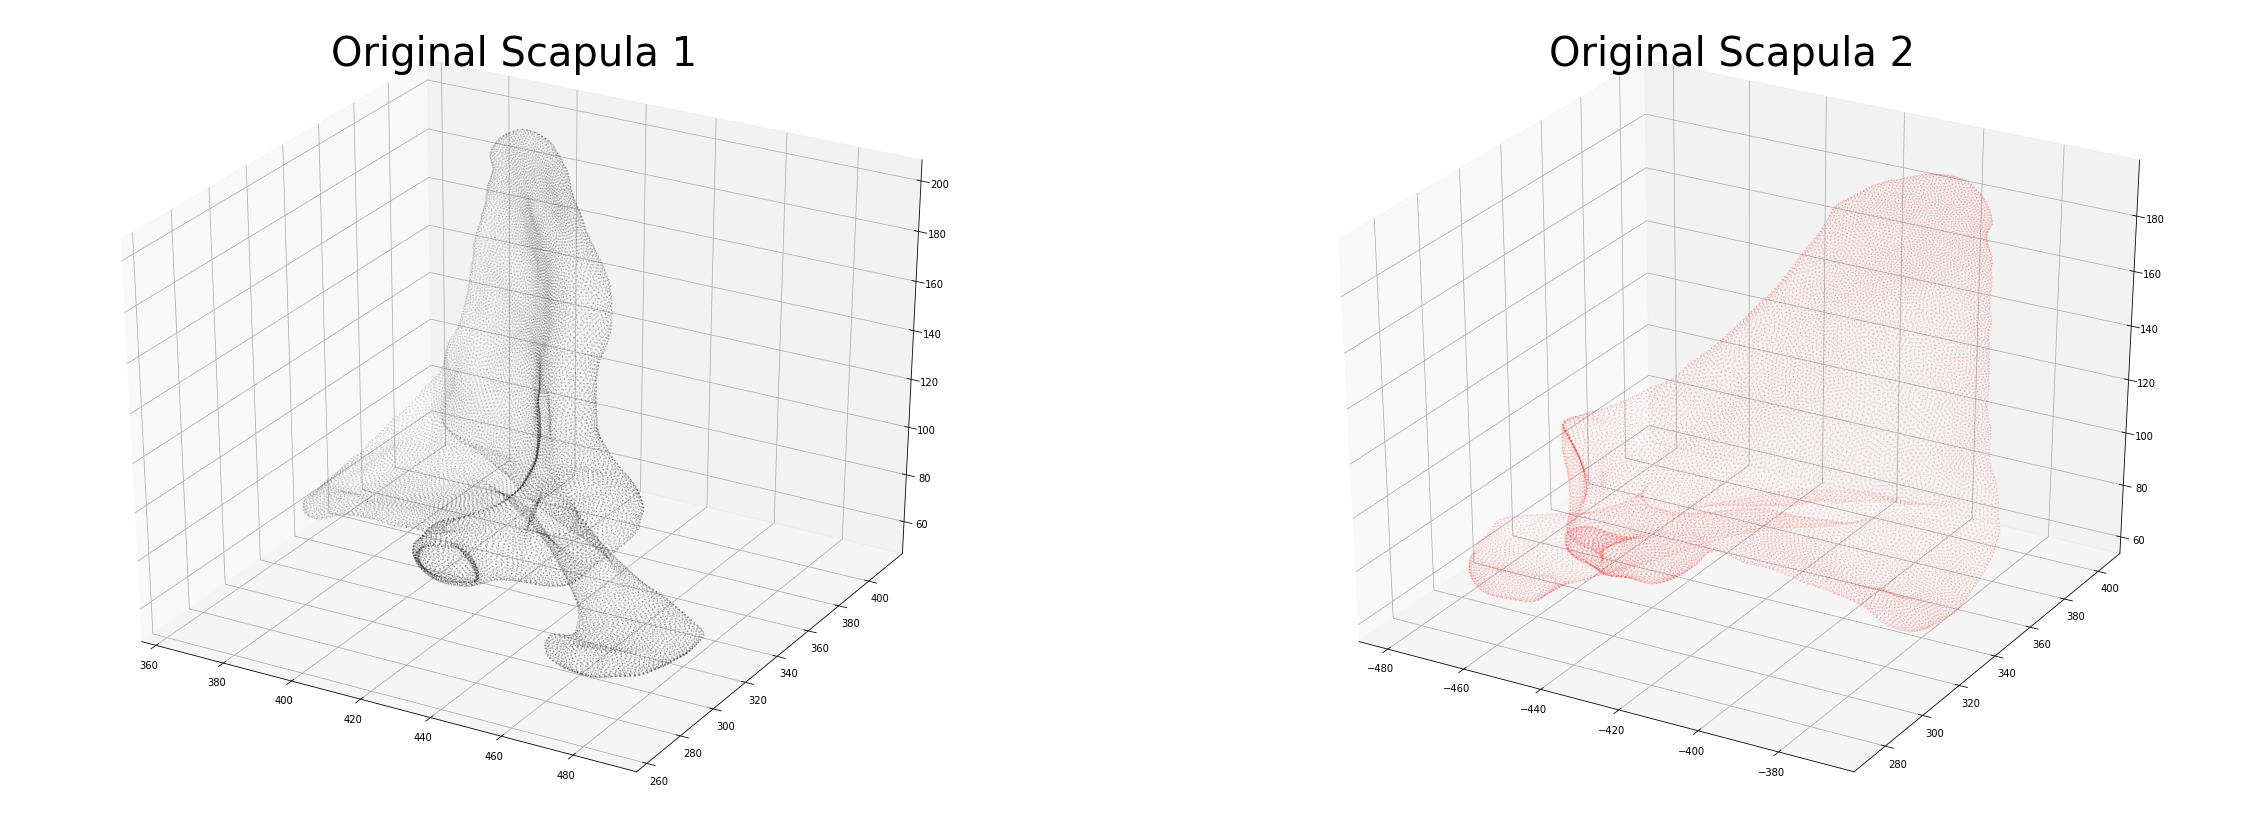

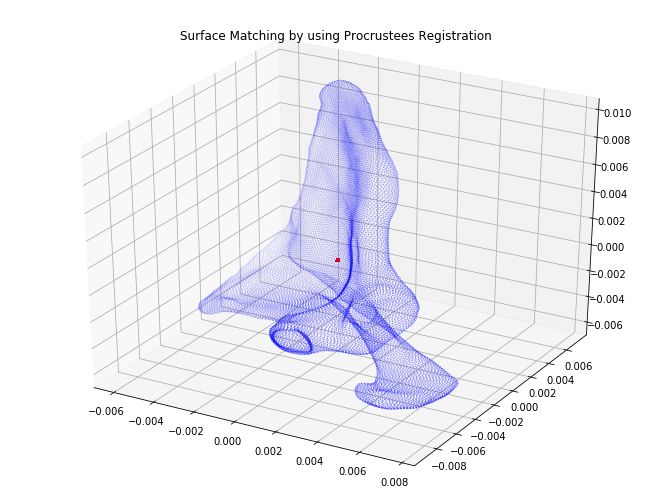

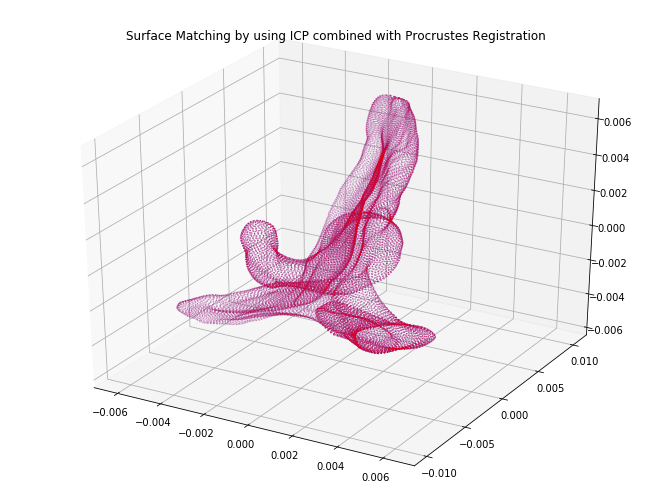

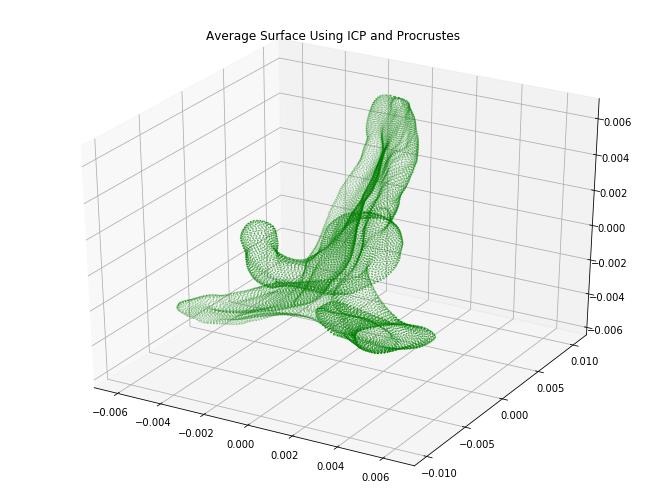

In [328]:
#create copies of arrays
mesh1_b = mesh1.copy()
mesh2_b = mesh2.copy()

#Applying procrustees to match mesh2 to mesh1
matrix1_, mesh2_matched_to_mesh1_, disparity_1 = procrustes(mesh1_b.vertices, mesh2_b.vertices)

#PROPOSED IDEA USE Interactive Closest point to register and then apply Procrustes to register further
matrix,trans,_= trimesh.registration.icp(mesh2_b.vertices,mesh1_b.vertices)
matrix1, mesh2_matched_to_mesh1, disparity_1 = procrustes(trans, mesh2_b.vertices)
calculate average surface
average = (matrix1 + mesh2_matched_to_mesh1)/2

fig = plt.figure(1, figsize = (40,15))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.scatter(mesh1.vertices[:,0],mesh1.vertices[:,1], mesh1.vertices[:,2], s=0.03, color = 'k')
plt.title('Original Scapula 1', size=(40))

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(mesh2.vertices[:,0],mesh2.vertices[:,1], mesh2.vertices[:,2], s=0.03, color='r')
plt.title('Original Scapula 2',size=(40))


#Proc plot
fig1 = plt.figure(2, figsize = (40,9))
ax1 = fig1.add_subplot(1,3,1, projection='3d')
ax1.scatter(matrix1_[:,0],matrix1_[:,1],matrix1_[:,2], s=0.03, color = 'blue')
ax1.scatter(mesh2_matched_to_mesh1_[:,0],mesh2_matched_to_mesh1_[:,1],mesh2_matched_to_mesh1_[:,2], s=0.03, color = 'red')
plt.title('Surface Matching by using Procrustees Registration')

#FROM THIS PLOT IT CAN BE SEEN THAT PROCRUSTEES DOES NOT MEET A GOOD STANDARD


#ICP + Proc Plot
fig2 = plt.figure(3, figsize = (40,9))
ax1 = fig2.add_subplot(1,3,1, projection='3d')
ax1.scatter(matrix1[:,0],matrix1[:,1],matrix1[:,2], s=0.03, color = 'blue')
ax1.scatter(mesh2_matched_to_mesh1[:,0],mesh2_matched_to_mesh1[:,1],mesh2_matched_to_mesh1[:,2], s=0.03, color = 'red')
plt.title('Surface Matching by using ICP combined with Procrustes Registration')


#Average Surface Plot
fig3 = plt.figure(4, figsize = (40,9))
ax1 = fig3.add_subplot(1,3,1, projection='3d')
ax1.scatter(average[:,0],average[:,1],average[:,2], s=0.09, color = 'green')
plt.title('Average Surface Using ICP and Procrustes ')

plt.show()

**Observations**
* As it can be seen from the surface plot above procrustes did not perfrom all that well to mathc the two surfaces
* Secondly using ICP and procrustes combined provided a better average surface, and this was used instead of the suggestion proposed in the intial question